# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

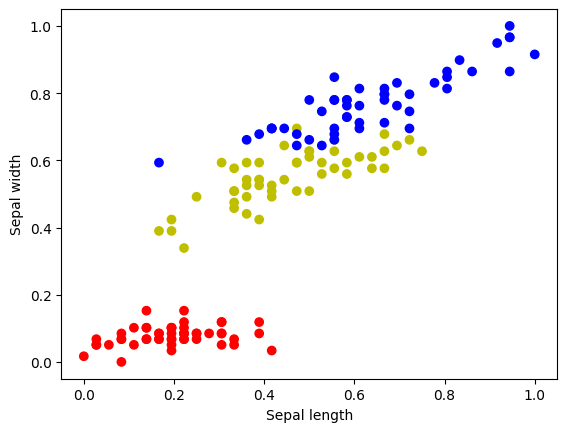

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [5]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [6]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ 0.6069, -0.1413],
                      [-0.6272,  0.2598],
                      [ 0.4839,  0.5078]])),
             ('bias', tensor([ 0.5399,  0.6108, -0.0726]))])

### Fazendo um predict

In [7]:
out = model(X_tensor[:4,:]) # 4 amostras
out

tensor([[0.6652, 0.4890, 0.0694],
        [0.6315, 0.5239, 0.0425],
        [0.6001, 0.5543, 0.0070],
        [0.5785, 0.5805, 0.0108]], grad_fn=<AddmmBackward0>)

In [8]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.4185, 0.3509, 0.2306],
        [0.4077, 0.3661, 0.2262],
        [0.3988, 0.3809, 0.2204],
        [0.3893, 0.3901, 0.2207]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [9]:
F.softmax(out,dim=1)*100

tensor([[41.8480, 35.0883, 23.0637],
        [40.7683, 36.6089, 22.6228],
        [39.8758, 38.0888, 22.0355],
        [38.9278, 39.0067, 22.0654]], grad_fn=<MulBackward0>)

### Predição da classe

In [10]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([0, 0, 0, 1])
tensor([0.4185, 0.4077, 0.3988, 0.3901], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [11]:
from IPython import display

def predict(model, inputs):
    outputs = model(inputs)
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(inputs)
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [33]:
lr = 1.5

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.09212549775838852


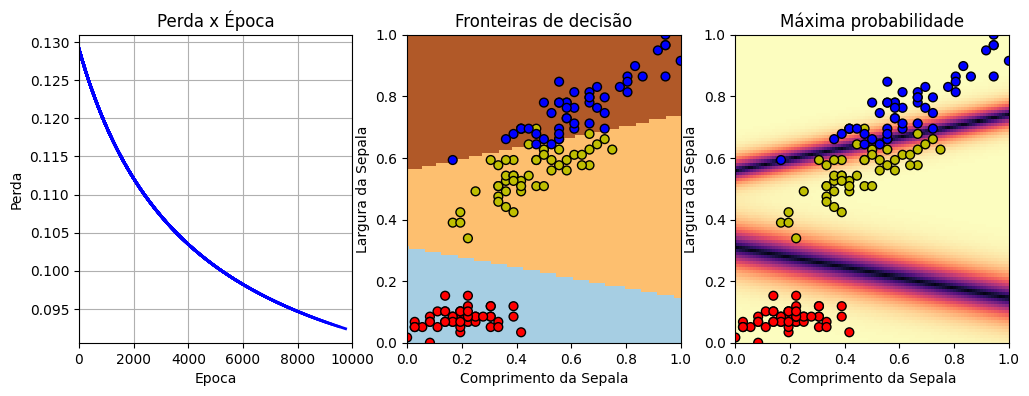

In [34]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model((X_tensor))

    # calcula a perda
    loss = criterion(output, (Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [14]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.6579, -14.5667],
                      [  1.8158,  -0.4279],
                      [  1.3057,  15.6209]])),
             ('bias', tensor([ 7.3277,  2.0040, -8.2535]))])

### Salvando os parâmetros treinados

In [15]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [16]:
! ls ../models/

RegrLog_Iris.pt


In [17]:
nn.init.constant(model.weight,0)
model.state_dict()

/tmp/ipython-input-952960416.py:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 7.3277,  2.0040, -8.2535]))])

### Recuperando os pesos salvos

In [18]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.6579, -14.5667],
                      [  1.8158,  -0.4279],
                      [  1.3057,  15.6209]])),
             ('bias', tensor([ 7.3277,  2.0040, -8.2535]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [19]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [20]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

2. Experimente refazer o treinamento com diferentes valores de learning rate

## R: 1. para que o treinamento comece do zero mesmo novamente e com novos parâmetros, é necessário re-executar a célula onde o objeto do modelo é definido. isso cria uma instância nova do nn.linear ou da classe net dele, e sobrescreve os pesos que foram treinados, resumindo a rede armazena o estado de meória e para zera-lo, devemos re-instanciar o objeto model antes de  rodar o laço de treinamento de novo

In [27]:
model = nn.Linear(2, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 2. o que muda com learning rates diferentes?

R:

com o learning rate 0.01 o que muda?

R: é possível ver que esse learning rate é baixo demais para esse problema, com o comportamento de perda, o custo mal se mexe, ela comea em aproximadamente 1.1 e só atinge cerca de 1.08 depois de 10.000 épocas(epochs), a taxa de convergência é tão pequena que o modelo leva passos insignificantes em direção ao mínimo da função de custo, então em conclusão está provado que 0.01 é ineficiente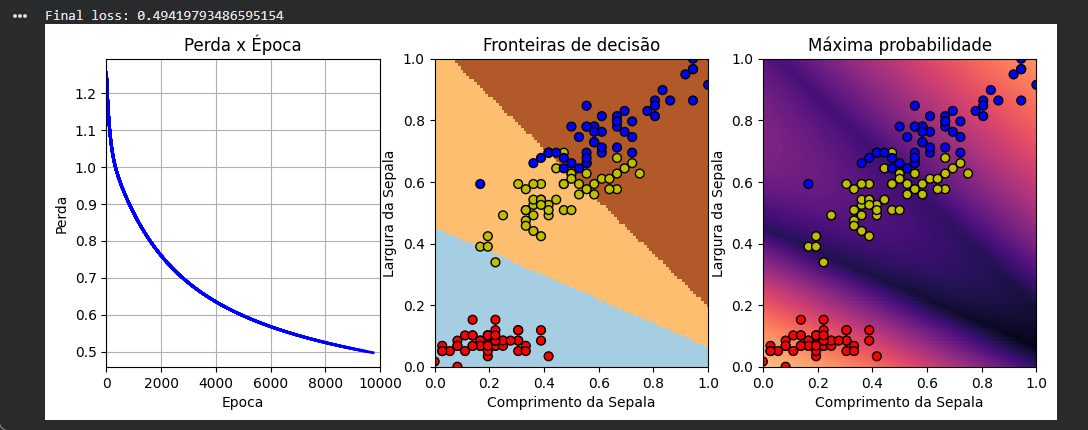

esse cenário de learning rate 0.5 mostra o valor ideal para esse modelo, porque contrasta muito em relação ao teste com o learning rate de 0.01, a perda cai bem rapido no início porque ele está dando passos de tamanho adequado para otimizar os pesos, depois ele se estabiliza de forma suave em um valor baixo, que é mais ou menos o de 0.5, mostrando que o modelo se convergiu de forma eficiente e estável, nem se compara com o de 0.01 que mal se mexia, isso mostra que o valor de 0.5 é uma taxa eficiente para esse problema de classificação
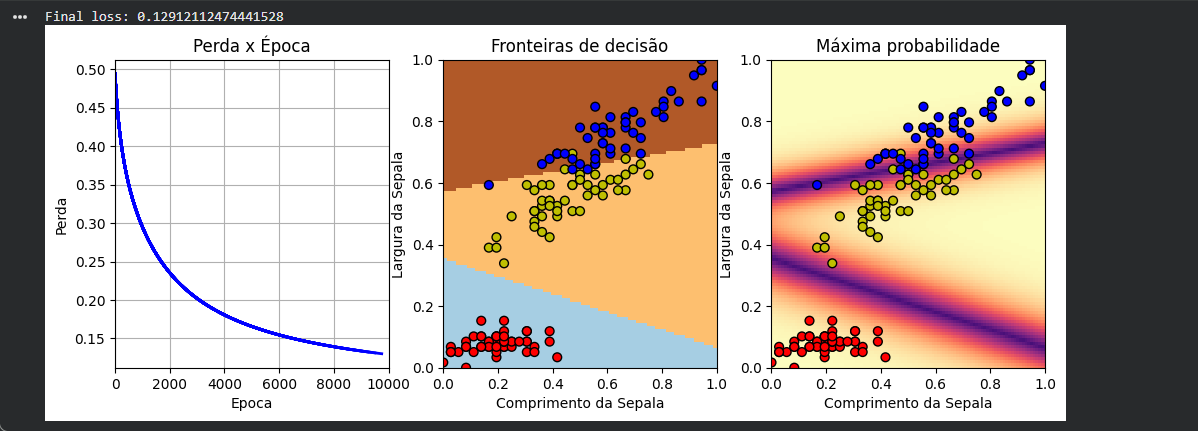

com o learning rate de 1.5 dá para observar que a curva oscila descontroladamente e falha em atingir um mínimo suave, ele está dando passos grandes demais e ultrapassando o ponto mínimo constantemente(overshooting), e a perda continua alta e instável, sem convergir de forma significativa, a taxa de aprendizado dele é alta demais e isso resulta em instabilidade e divergência do modelo
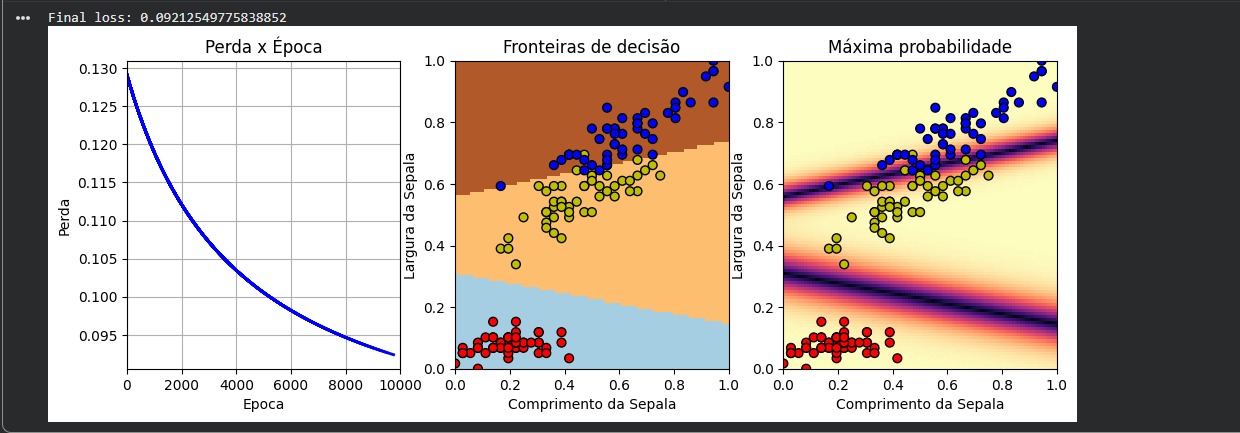

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
    R: É o dado mais distante da fronteira de decisão, representando o acerto de maior confiança do modelo.

    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    R: Esta é uma falha de classificação com alta confiança. O erro ocorre em regiões onde a sobreposição das classes impede a separação linear ideal.
    
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    R: É o acerto mais desafiador, localizado adjacente à fronteira de decisão, onde a confiança do modelo é a mais baixa.

    4. Qual é a amostra classificada erradamente, com menor probabilidade?
    R: O erro de menor confiança, posicionado na própria margem de decisão. O modelo classificou incorretamente por uma margem muito estreita.

2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
    R: O número total de parâmetros que a rede treina é 9. Este valor é composto por 6 pesos (ligações da camada densa) e 3 termos de viés (bias), um para cada classe de saída.

3. Quantas entradas e quantas saídas esta rede possui?
    R: A rede processa 2 atributos na entrada (as features do dataset) e produz 3 saídas (o número total de classes).

4. Como se pode calcular a acurácia a partir da matriz de confusão?
    R: A acurácia geral é obtida dividindo a soma dos elementos na diagonal principal da matriz de confusão (os acertos) pelo total de todas as amostras avaliadas.

5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

    R: A função torch.max() retorna um par de tensores: values (os valores máximos/probabilidades) e indices (os índices das classes onde o máximo ocorre, ou seja, as classes preditas).

## Principais aprendizados

fundamentos de regressão linear, o papel do bias ou viés, dimensionalidade e parâmetros, algoritmos de otimização e estabilidade que tem a importância do learning rate, análise e estabilidade e boas práticas do pytorch